In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
def dist_ar(xc=None, yc=None):
    """
    returns a 2D array with distance to each pixel from a custom centre pixel, (xc, yc)
    """
    d_ar = np.zeros(npeaks.shape)
    for i in range(d_ar.shape[0]):
        for j in range(d_ar.shape[1]):
            d_ar[i,j] = np.hypot(xc - j, yc - i)
        
    return d_ar

### Parameter distance 
#### $dp = \sqrt{\left( w_{\rm v} \times \frac{\rm \Delta v_{LSR}}{\rm v_{norm}} \right)^2 + \left( (1 - w_{\rm v}) \times \frac{\rm \Delta T_{TM}}{\rm T_{MB,norm}} \right)^2}$

In [3]:
def para_dist(v1=None, v2=None, tmb1=None, tmb2=None, vel_norm=0.3, tmb_norm=3, w_vel=0.5):
    """
    returns normalised combined 'distance' in velocity and T_MB
    
    v1, v2 : velocities of the two pixels
    tmb1, tmb2 : main beam brightness temperatures of the two pixels
    
    vel_norm : normalisation factor for difference in velocities
    tmb_norm : normalisation factor for difference in T_MB
    
    w_vel : weight for velocity 'distance'. T_MB diff gets weight (1-w)
    """
    
    vl_dist = np.abs((v1 - v2) / vel_norm)
    tmb_dist = np.abs((tmb1 - tmb2) / tmb_norm)
    
    dist = np.hypot(vl_dist*w_vel, (1-w_vel)*tmb_dist)
    
    return dist

### Aplpy plots

In [6]:
from aplpy import FITSFigure
from astropy.io.fits import PrimaryHDU
import astropy.units as u

import matplotlib as mpl
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [7]:
def aplpy_plot(fig= None, data=None, hd=None, cmap='inferno', vmin=9.7, vmax=10.7, colourbar=True, bm_clr='k',
               colourbar_text=r'$\rm{v_{LSR}}\ (km\,s^{-1})$', beam_colour='green', fgsz=(7,7), zoom=False, 
               colourbar_loc='right', scalebar_corner='top right', sbplt=[0, 0, 1, 1], background_grey=False, 
               bckgr_gr_clr='0.8', x_bm_lbl=0.07, y_bm_lbl=0.07, colourscale_stretch='linear', vmid=None) :
    """ 
    return aplpy FITSfigure for given data
    """
    if not fig:
        fig = plt.figure(figsize=fgsz)
        
    fig = FITSFigure( data=PrimaryHDU(data=data, header=hd), figure=fig, subplot=sbplt)
    
    if background_grey:
        cmap = plt.get_cmap(cmap)
        cmap.set_bad(bckgr_gr_clr)
    
    fig.show_colorscale( cmap=cmap, vmin=vmin, vmax=vmax,stretch=colourscale_stretch, vmid=vmid)
    
    if colourbar:
        fig.add_colorbar()
        fig.colorbar.show(location=colourbar_loc, axis_label_text=colourbar_text)
    
    fig.add_beam(color=beam_colour)
    
    distance = 302 *u.pc
    scale=(0.1*u.pc/distance*u.rad).to(u.deg)
    fig.add_scalebar(scale, label='0.1 pc', corner=scalebar_corner)
#     fig.set_nan_color('0.7')
    fig.ticks.set_color('black')
    fig.add_label( x_bm_lbl, y_bm_lbl, 'B5', relative=True, color= bm_clr, size=15)
    
    if zoom:
        fig.recenter(56.914, 32.879, width=0.13, height=0.138)
        
    return fig

### read in master arrays

##### * The velocity, velocity dispersion and the $T_{MB}$ for all components are stored in the arrays 'vel_master', 'sig_master', and 'tmb_master' (without any prior sorting)
##### * Both arrays have shapes (3, y, x). Each pixels have 3 values, corresponding to the velocity (or $T_{MB}$) of the 3 components in that pixel. The second (and third) values are NaNs where the pixels have only two (or one) components

In [9]:
vel_master, hd3d = fits.getdata('para_hypercubes/vel_3cmp_master.fits', header=True)
sig_master = fits.getdata('para_hypercubes/sig_3cmp_master.fits')
tmb_master = fits.getdata('para_hypercubes/tmb_3cmp_master.fits')

### sort the different components based on the combined parameter distance

In [7]:
def sort_nearest_neighbour(x_start=None, y_start=None, mask=None, rad_asign=1.0, **kargs):
    
    """
    sorts the parameter maps based on combined parametric distance 
    
    
    inputs:
    x_start, y_start : co-ordinates of the pixel to start the sorting         ; required
    mask             : mask within which to do the sorting                    ; optional
    rad_assign.      : radius (in pix) to define the neighbourhood of a pixel ; default is 1
    
    further inputs can be passed into para_dist
    
    outputs :
    vel_sig_tmb_1, vel_sig_tmb_2, vel_sig_tmb_3 : arrays with shapes (3,:,:), corresponding to the component 
                                                  which is kinematically coherent in the largest extent, and the 
                                                  remaining components (which is to be sorted further), respectively
                                                  
                                                  each pixel in each of these arrays has three values, the velocity, 
                                                  velocity dispersion and T_MB at that pixel, for the corresponding 
                                                  copmponent
            
    """
    
    # create arrays to store the components after sorting
  
    vel_sig_tmb_1 = np.ones((3,)+ npeaks.shape) * np.nan
    vel_sig_tmb_2 = np.ones((3,)+ npeaks.shape) * np.nan
    vel_sig_tmb_3 = np.ones((3,)+ npeaks.shape) * np.nan
    
    # assign the velocity, velocity dispersion and T_MB at the starting pixel
    
    vel_sig_tmb_1[:,y_start, x_start] = [vel_master[0, y_start, x_start], sig_master[0, y_start, x_start], 
                                       tmb_master[0, y_start, x_start]]
    
    # create distance array with the reference as the starting pixel : 
    # the value at each pixel is the distance to that pixel from the reference
    
    dist_to_pixels = dist_ar(xc=x_start, yc=y_start)
    
    # apply mask if provided, if not apply a basic mask, to ensure no pixel without a good fit is tried
    
    try:
        y_list, x_list = np.where(mask)
    except :
        y_list, x_list = np.where(tmb_master[0, :, :] > 0)
    
    # distance to pixels within the mask
    dist_1d_array = dist_to_pixels[y_list, x_list]
    
    # sort the indices of the distance array in increasing order
    sorted_index = np.argsort(dist_1d_array)
    
    """
    The sorting is done in the following steps :
     1. Start from the starting pixel, go to the next pixel in order of distance from the starting pixel, 
        and continue in this order
     
     2. Calculate the mean velocity and Tmb within the radius provided in input. In the first iteration, 
        this is just the velocity and Tmb of the starting pixel
       
     3. Calculate the parameter distances for all three components with respect to the mean velocity and Tmb 
        calculated above
        
     4. Sort the component with the minimum parameter distance to the first array, 
        and the other two components (if present) to the other two arrays. 
    """
    for indx in sorted_index:
        
        xi, yi = x_list[indx], y_list[indx]
        dist_i = dist_ar(xc=xi, yc=yi)
        gd_idx = np.where(dist_i <= rad_asign)           
        
        vel_1_all = vel_sig_tmb_1[0, :, :]
        tmb_1_all = vel_sig_tmb_1[2, :, :]

        # calculate mean refgerence values for assigmnent
        vel_1_mean = np.nanmean(vel_1_all[gd_idx])
        tmb_1_mean = np.nanmean(tmb_1_all[gd_idx])
        
        para_dist_1 = para_dist(v1=vel_master[0, yi, xi], tmb1=tmb_master[0, yi, xi], 
                                v2=vel_1_mean, tmb2=tmb_1_mean, **kargs)
        para_dist_2 = para_dist(v1=vel_master[1, yi, xi], tmb1=tmb_master[1, yi, xi], 
                                v2=vel_1_mean, tmb2=tmb_1_mean, **kargs)
        para_dist_3 = para_dist(v1=vel_master[2, yi, xi], tmb1=tmb_master[2, yi, xi], 
                                v2=vel_1_mean, tmb2=tmb_1_mean, **kargs)
        
        para_dist_min = np.nanmin([para_dist_1, para_dist_2, para_dist_3])
        
        if para_dist_1 == para_dist_min:
            vel_sig_tmb_1[:, yi, xi] = [vel_master[0, yi, xi], sig_master[0, yi, xi], tmb_master[0, yi, xi]]
            vel_sig_tmb_2[:, yi, xi] = [vel_master[1, yi, xi], sig_master[1, yi, xi], tmb_master[1, yi, xi]]
            vel_sig_tmb_3[:, yi, xi] = [vel_master[2, yi, xi], sig_master[2, yi, xi], tmb_master[2, yi, xi]]
            
        elif para_dist_2 == para_dist_min:
            vel_sig_tmb_1[:, yi, xi] = [vel_master[1, yi, xi], sig_master[1, yi, xi], tmb_master[1, yi, xi]]
            vel_sig_tmb_2[:, yi, xi] = [vel_master[2, yi, xi], sig_master[2, yi, xi], tmb_master[2, yi, xi]]
            vel_sig_tmb_3[:, yi, xi] = [vel_master[0, yi, xi], sig_master[0, yi, xi], tmb_master[0, yi, xi]]
            
        elif para_dist_3 == para_dist_min:

            vel_sig_tmb_1[:, yi, xi] = [vel_master[2, yi, xi], sig_master[2, yi, xi], tmb_master[2, yi, xi]]
            vel_sig_tmb_2[:, yi, xi] = [vel_master[0, yi, xi], sig_master[0, yi, xi], tmb_master[0, yi, xi]]
            vel_sig_tmb_3[:, yi, xi] = [vel_master[1, yi, xi], sig_master[1, yi, xi], tmb_master[1, yi, xi]]
        
    return vel_sig_tmb_1, vel_sig_tmb_2, vel_sig_tmb_3

## sort the components

In [ ]:
# arr1 corresponds to `component 1' in the paper

# starting pixel is selected from a region with only one component, for clear component assignment

arr1, arr2, arr3 = sort_nearest_neighbour_v2(x_start=77, y_start=115, w_vel=0.5, rad_asign=2, 
                                             vel_norm=1, tmb_norm=7.5)

In [ ]:
fits.writeto('sorted_comps/first_sort_vel-sig-tmb_extended.fits', arr1_1, hd3d, overwrite=True)
fits.writeto('sorted_comps/first_sort_vel-sig-tmb_extra-1.fits', arr2_1, hd3d, overwrite=True)
fits.writeto('sorted_comps/first_sort_vel-sig-tmb_extra-2.fits', arr3_1, hd3d, overwrite=True)

In [3]:
arr1 = fits.getdata('sorted_comps/first_sort_vel-sig-tmb_extended.fits')
arr2 = fits.getdata('sorted_comps/first_sort_vel-sig-tmb_extra-1.fits')
arr3 = fits.getdata('sorted_comps/first_sort_vel-sig-tmb_extra-2.fits')

In [4]:
snr, hd2d = fits.getdata('bayesian_fit_files/snr11.fits', header=True)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


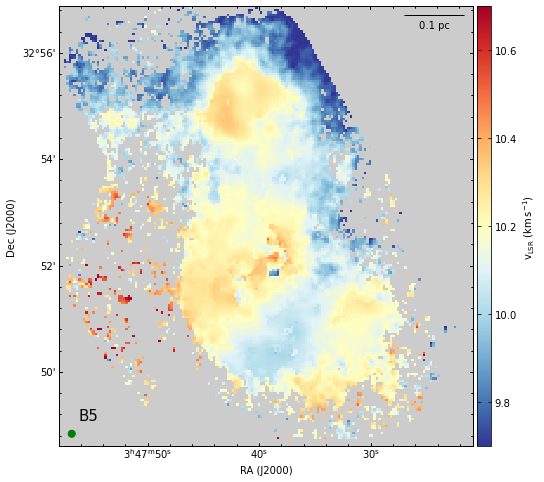

In [8]:
vel_ext = arr1[0]*(snr>4)
vel_ext[vel_ext == 0] = np.nan

fig = aplpy_plot(data=vel_ext, hd=hd2d, cmap='RdYlBu_r', zoom=True, fgsz=(6,10), background_grey=True)

In [10]:
fits.writeto('sorted_comps/vel_extended.fits', vel_ext, hd3d, overwrite=True)

### Sort the additional components into four velocity coherent components : 
#### deep red, red, blue, deep blue 

In [19]:
def comp_sort_into_4_vel_cut(vel_sig_tmb_ar_1=None, vel_sig_tmb_ar_2=None, 
                             vel_cut_low=9.7, vel_cut_mid=10.15, vel_cut_high=40.4, 
                             ret_num_of_comp_per_pixel=False) :
    
    sort_ar_1 = np.ones(vel_sig_tmb_ar_1.shape)*np.nan
    sort_ar_2 = np.ones(vel_sig_tmb_ar_1.shape)*np.nan
    sort_ar_3 = np.ones(vel_sig_tmb_ar_1.shape)*np.nan
    sort_ar_4 = np.ones(vel_sig_tmb_ar_1.shape)*np.nan
    
    ar_num_comp_1 = np.zeros(vel_sig_tmb_ar_1.shape[1:])
    ar_num_comp_2 = np.zeros(vel_sig_tmb_ar_1.shape[1:])
    ar_num_comp_3 = np.zeros(vel_sig_tmb_ar_1.shape[1:])
    ar_num_comp_4 = np.zeros(vel_sig_tmb_ar_1.shape[1:])
    
    
    
    for i in range(sort_ar_1.shape[1]):
        for j in range(sort_ar_1.shape[2]):
            
#             if vel_cut_from_map:
#                 vel_cut = vel_map_ref[i,j]
                
            if vel_sig_tmb_ar_1[0, i, j] < vel_cut_low :
                sort_ar_1[:, i, j] = vel_sig_tmb_ar_1[:, i, j]
                ar_num_comp_1[i,j] += 1
            elif vel_sig_tmb_ar_1[0, i, j] > vel_cut_low and vel_sig_tmb_ar_1[0, i, j] < vel_cut_mid :
                sort_ar_2[:, i, j] = vel_sig_tmb_ar_1[:, i, j]
                ar_num_comp_2[i,j] += 1
            elif vel_sig_tmb_ar_1[0, i, j] >vel_cut_mid and vel_sig_tmb_ar_1[0, i, j] < vel_cut_high :
                sort_ar_3[:, i, j] = vel_sig_tmb_ar_1[:, i, j]
                ar_num_comp_3[i,j] += 1
            elif vel_sig_tmb_ar_1[0, i, j] > vel_cut_high:
                sort_ar_4[:, i, j] = vel_sig_tmb_ar_1[:, i, j]
                ar_num_comp_4[i,j] += 1
                
            if vel_sig_tmb_ar_2[0, i, j] < vel_cut_low :
                sort_ar_1[:, i, j] = vel_sig_tmb_ar_2[:, i, j]
                ar_num_comp_1[i,j] += 1
            elif vel_sig_tmb_ar_2[0, i, j] > vel_cut_low and vel_sig_tmb_ar_2[0, i, j] < vel_cut_mid :
                sort_ar_2[:, i, j] = vel_sig_tmb_ar_2[:, i, j]
                ar_num_comp_2[i,j] += 1
            elif vel_sig_tmb_ar_2[0, i, j] >vel_cut_mid and vel_sig_tmb_ar_2[0, i, j] < vel_cut_high :
                sort_ar_3[:, i, j] = vel_sig_tmb_ar_2[:, i, j]
                ar_num_comp_3[i,j] += 1
            elif vel_sig_tmb_ar_2[0, i, j] > vel_cut_high:
                sort_ar_4[:, i, j] = vel_sig_tmb_ar_2[:, i, j]
                ar_num_comp_4[i,j] += 1
    
    if ret_num_of_comp_per_pixel:
        return ar_num_comp_1, ar_num_comp_2, ar_num_comp_3, ar_num_comp_4
    
    return sort_ar_1, sort_ar_2, sort_ar_3, sort_ar_4

In [20]:
# three velocity cuts to separate the four components : these velocities are selected through visual inspection
v1 = 9.8
v2 = 10.13
v3 = 10.5

dark_blue_arr, mid_blue_arr, mid_red_arr, dark_red_arr = comp_sort_into_4_vel_cut(vel_sig_tmb_ar_1=arr2, 
                                                                                  vel_sig_tmb_ar_2=arr3, 
                                                                                  vel_cut_low=v1, vel_cut_mid=v2, 
                                                                                  vel_cut_high=v3)

In [ ]:
fits.writeto('sorted_comps/dark_blue_vel-sig-tmb.fits', dark_blue_arr, hd_3_para, overwrite=True)
fits.writeto('sorted_comps/mid_blue_vel-sig-tmb.fits', mid_blue_arr, hd_3_para, overwrite=True)
fits.writeto('sorted_comps/mid_red_vel-sig-tmb.fits', mid_red_arr, hd_3_para, overwrite=True)
fits.writeto('sorted_comps/dark_red_vel-sig-tmb.fits', dark_red_arr, hd_3_para, overwrite=True)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


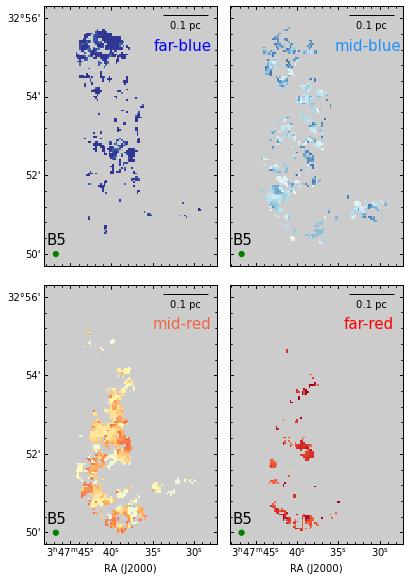

In [23]:
fig = plt.figure(figsize=(6,9))

fig1 = aplpy_plot(fig=fig, data=dark_blue_arr[0], hd=hd2d, cmap='RdYlBu_r', zoom=True, sbplt=[0.12, 0.5, 0.4, 0.4], 
                  colourbar=False, vmin=9.7, vmax=10.7, background_grey=True, y_bm_lbl=0.1)

fig1.tick_labels.hide_x()
fig1.axis_labels.hide()


fig2 = aplpy_plot(fig=fig, data=mid_blue_arr[0], hd=hd2d, cmap='RdYlBu_r', zoom=True, sbplt=[0.55, 0.5, 0.4, 0.4], 
                  colourbar=False, vmin=9.7, vmax=10.7, background_grey=True, y_bm_lbl=0.1)
fig2.tick_labels.hide()
fig2.axis_labels.hide()

fig3 = aplpy_plot(fig=fig, data=mid_red_arr[0], hd=hd2d, cmap='RdYlBu_r', zoom=True, sbplt=[0.12, 0.07, 0.4, 0.4], 
                  colourbar=False, vmin=9.7, vmax=10.7, background_grey=True, y_bm_lbl=0.1)
fig3.axis_labels.hide_y()

fig4 = aplpy_plot(fig=fig, data=dark_red_arr[0], hd=hd2d, cmap='RdYlBu_r', zoom=True, sbplt=[0.55, 0.07, 0.4, 0.4], 
                  colourbar=False, vmin=9.7, vmax=10.7, background_grey=True, y_bm_lbl=0.1)
fig4.tick_labels.hide_y()
fig4.axis_labels.hide_y()

fig1.recenter(56.907, 32.8833, width=0.07, height=0.11)
fig2.recenter(56.907, 32.8833, width=0.07, height=0.11)
fig3.recenter(56.907, 32.8833, width=0.07, height=0.11)
fig4.recenter(56.907, 32.8833, width=0.07, height=0.11)


fig1.add_label( 0.8, 0.85, 'far-blue', relative=True, color='b', size=15, weight=500)
fig2.add_label( 0.8, 0.85, 'mid-blue', relative=True, color='dodgerblue', size=15, weight=500)
fig3.add_label( 0.8, 0.85, 'mid-red', relative=True, color='#ef6548', size=15, weight=500)
fig4.add_label( 0.8, 0.85, 'far-red', relative=True, color='r', size=15, weight=500)

### Additional : show histograms of the additional components (sort_3cmp)

### Additional : show 2d KDE of the additional components (sort_3cmp)